In [1]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, kstest, norm, chisquare, kendalltau, multiscale_graphcorr
from pandas.plotting import parallel_coordinates
import re

class data_ana:
    def __init__(self, address, flag=False):
        if flag:
            self.dt = pd.read_csv(address)
            self.dt = self.dt[self.dt.columns[1:]]
            self.dt_exp = dict()
            return

        self.dt = pd.read_csv(address)
        self.dt.columns = [col.lower() for col in self.dt.columns]
        cd_t = pd.to_datetime(self.dt['crash_date'], format='%m/%d/%Y %I:%M:%S %p')
        dpn = pd.to_datetime(self.dt['date_police_notified'], format='%m/%d/%Y %I:%M:%S %p')
        self.dt.drop(columns=['location', 'most_severe_injury', 'crash_record_id',
                              'crash_date', 'crash_month', 'alignment',
                              'beat_of_occurrence', 'device_condition',
                              'date_police_notified', 'road_defect'], inplace=True)
        self.dt = self.dt.filter(regex="^(?!injuries_[a-su-z])")
        self.dt = self.dt.filter(regex="^(?!street)")
        self.dt['crash_day_of_week'].replace({1: 8}, inplace=True)
        self.dt['crash_hour'].replace({0: 24}, inplace=True)
        bins = [1, 6, 9]
        labels = [0, 1]
        self.dt['crash_day_of_week'] = pd.cut(self.dt['crash_day_of_week'], bins=bins, labels=labels, right=False)
        bins = [0, 6, 12, 20, 25]
        labels = [0, 1, 2, 3]
        self.dt['crash_hour'] = pd.cut(self.dt['crash_hour'], bins=bins, labels=labels, right=False)
        self.dt['efficiency'] = (dpn - cd_t).dt.seconds/60
        self.dt.info()
        self.row, self.col = self.dt.shape
        self.need_fill = None
        self.dt_exp = dict()
        self.ind_list = []
        # self.flag = False

    def normal_data_vis(self, dta, ttyp='', for_para = 'damage'):
        if ttyp == 'hist':
            sb.set(style='whitegrid')
            sb.histplot(self.dt[dta])
            plt.title(dta)
            plt.show()
        if ttyp == 'norm':
            sb.distplot(self.dt[dta], bins=100, norm_hist=True,
                        color='g', label='Data dis', kde=True)
            plt.title(f'hist and norm of {dta}')
            plt.xlabel('Values')
            plt.ylabel('Freq')
            plt.legend()
            plt.show()
        if ttyp == 'box':
            self.dt.boxplot(dta)
            plt.title(f'boxplot of all feature')
            plt.show()
        if ttyp == 'hm':
            cm = dta.corr(numeric_only=False, method='spearman')
            plt.figure(figsize=(10, 8))
            sb.heatmap(cm, annot=True, cmap='coolwarm', linewidths=0.5)
            plt.title("Correlation Heatmap")
            plt.show()
        if ttyp == 'para':

            parallel_coordinates(dta, for_para, colormap=plt.get_cmap('Set2'))
            plt.title(f"para map for {for_para}")
            plt.show()

    def data_fill(self, descript):
        pass

    def dup_check(self):
        return True if self.dt.duplicated().values.any() else False

    def nan_detail(self, thr=0.5):
        if self.dt.isna().values.any():
            h1 = self.dt.isna().sum()
            h1 = h1[h1 != 0]
            per_re = h1/self.row
            should_remove = per_re[per_re >= thr].index
            # print(should_remove)
            self.dt.drop(columns=[*should_remove], inplace=True)
            self.col = self.col - len(should_remove)
            self.need_fill = per_re[per_re < thr]
            print(self.dt.info())
            print(self.need_fill)
            return False
        else:
            return True

    def obj_switch(self):
        for i in self.dt.columns:
            if self.dt[i].dtype == 'object':
                self.dt[i], label = pd.factorize(self.dt[i])
                self.dt_exp.update({i: label})

    def mod_miss(self):
        for i in self.need_fill.index:
            current_col = self.dt[i]
            if current_col.dtype == 'object':
                self.dt[i], label = pd.factorize(current_col)
                self.dt_exp.update({i: label})
                print(label)
                if len(label) <= 3:
                    # self.normal_data_vis(i, ttyp='hist')
                    self.dt[i].fillna(self.dt[i].mode()[0], inplace=True)
                else:
                    # self.normal_data_vis(i, ttyp='hist')
                    self.dt[i].fillna(self.dt[i].median(), inplace=True)
            else:
                # mu, sigma = current_col.mean(), current_col.std()
                # x = np.linspace(current_col.min(), current_col.max())
                helper = (current_col - current_col.mean()) / current_col.std()
                # self.normal_data_vis(i, ttyp='norm')
                stat, p = kstest(helper, N=5000, cdf='norm', nan_policy='omit')
                if p > 0.1:
                    self.dt[i].fillna(self.dt[i].mean(), inplace=True)
                else:
                    self.dt[i].fillna(self.dt[i].median(), inplace=True)
            # self.dt[i].fillna(self.dt[i].mode()[0], inplace=True)

    def outlier_deal(self):
        # self.normal_data_vis(self.dt.columns, ttyp='box')
        for col_name in self.dt.columns:
            if col_name in ['report_type', 'latitude', 'longitude', 'crash_hour', 'crash_day_of_week'] or self.dt[col_name].dtype == 'object':
                self.obj_deal(col_name)
                continue
            current = self.dt[col_name]
            low_out, median, high_out = current.quantile([0.01, 0.5, 0.99])
            ho = (current >= high_out)
            lo = (current <= low_out)
            self.dt.loc[ho, col_name] = np.nan
            self.dt.loc[lo, col_name] = np.nan
            if self.dt[col_name].dtype == 'int64':
                self.dt[col_name].fillna(int(median), inplace=True)
            else:
                self.dt[col_name].fillna(median, inplace=True)

    def obj_deal(self, col_name):
        if self.dt[col_name].dtype == 'object':
            self.dt[col_name], label = pd.factorize(self.dt[col_name])
            self.dt_exp.update({col_name: label})
            # self.flag = True
        else:
            return

    def corr_ana(self):
        self.dt.info()
        sample = self.dt.sample(n=5000, random_state=28)
        # self.normal_data_vis(sample, ttyp='para')
        self.normal_data_vis(sample, ttyp='hm')
        print(1)

    def display_sample(self, col_name):
        print(self.dt.loc[self.dt[col_name].idxmax()]) # show occ max
        print(self.dt[col_name].value_counts()) # show bal

    def result_save(self, addr):
        self.re_obj()
        self.dt.to_csv(addr)

    def re_obj(self):
        for i in self.dt_exp.keys():
            self.dt[i] = self.dt[i].apply(lambda x:self.dt_exp.get(i)[x])

    def pattern_ana(self, index):
        sample = self.dt.sample(n=100, random_state=28)
        sample.drop(columns=['efficiency', 'latitude', 'longitude',
                             'prim_contributory_cause', 'sec_contributory_cause'], inplace=True)
        for i in index:
            self.normal_data_vis(sample, ttyp='para', for_para=i)

    def check_all(self):
        for i in self.dt.columns:
            self.normal_data_vis(i, ttyp='hist')
            print(self.dt[i].value_counts())

In [2]:
post = data_ana('/kaggle/input/preprocess/preprocess_ds.csv', flag=True)
df = post.dt
df.head()

,posted_speed_limit,traffic_control_device,weather_condition,lighting_condition,first_crash_type,trafficway_type,roadway_surface_cond,report_type,crash_type,damage,prim_contributory_cause,sec_contributory_cause,num_units,injuries_total,crash_hour,crash_day_of_week,latitude,longitude,efficiency
0,30.0,TRAFFIC SIGNAL,CLEAR,DUSK,ANGLE,"FIVE POINT, OR MORE",DRY,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,"OVER $1,500",UNABLE TO DETERMINE,NOT APPLICABLE,2.0,0.0,2,0,41.874743,-87.674094,30.0
1,30.0,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",REAR END,DIVIDED - W/MEDIAN BARRIER,DRY,ON SCENE,NO INJURY / DRIVE AWAY,"OVER $1,500",FOLLOWING TOO CLOSELY,FOLLOWING TOO CLOSELY,2.0,0.0,2,1,41.874743,-87.674094,5.0
2,30.0,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),DRY,ON SCENE,NO INJURY / DRIVE AWAY,"OVER $1,500",FAILING TO REDUCE SPEED TO AVOID CRASH,"OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELE...",2.0,0.0,2,1,41.854120,-87.665902,30.0
3,30.0,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,NOT DIVIDED,DRY,ON SCENE,NO INJURY / DRIVE AWAY,"OVER $1,500",FAILING TO YIELD RIGHT-OF-WAY,NOT APPLICABLE,2.0,0.0,3,0,41.874743,-87.674094,40.0
4,15.0,OTHER,CLEAR,DAYLIGHT,REAR END,OTHER,DRY,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,"OVER $1,500",FOLLOWING TOO CLOSELY,DISTRACTION - FROM INSIDE VEHICLE,2.0,1.0,2,1,41.874743,-87.674094,5.0


A summary of posted speed limit at the crash location:
count    794956.000000
mean         28.602272
std           4.779328
min           6.000000
25%          30.000000
50%          30.000000
75%          30.000000
max          39.000000
Name: posted_speed_limit, dtype: float64


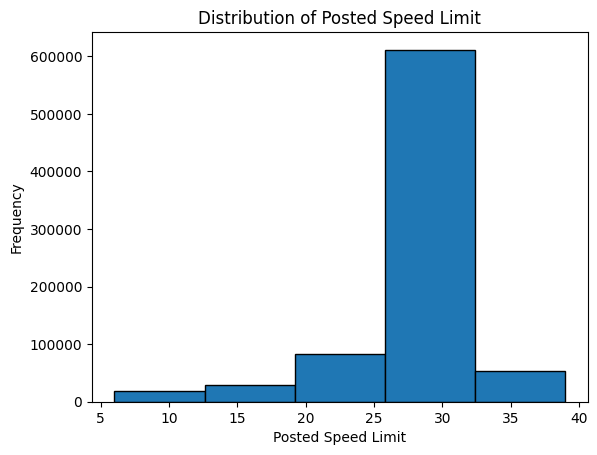

In [3]:
# Summary of posted_speed_limit
speed_limit = df['posted_speed_limit']
print('A summary of posted speed limit at the crash location:')
print(speed_limit.describe())

# Histogram
plt.hist(df['posted_speed_limit'], bins=5, edgecolor='black')
#plt.bar(speed_counts.index, height=speed_counts)
plt.title("Distribution of Posted Speed Limit")
plt.xlabel("Posted Speed Limit")
plt.ylabel("Frequency")
plt.show()

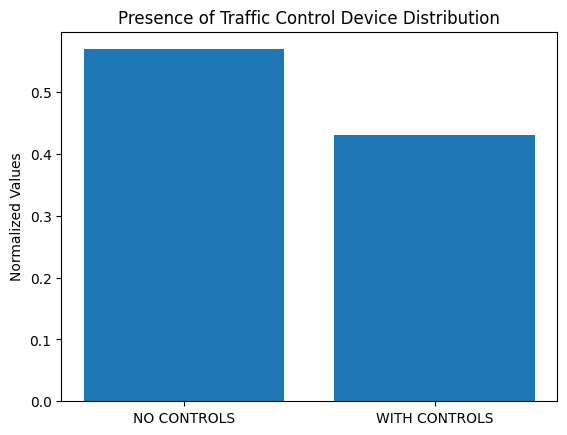

In [4]:
# Use of control device
df['any_control_device'] = np.where(df['traffic_control_device'] == 'NO CONTROLS', 'NO CONTROLS', 'WITH CONTROLS')

# Display the distribution of Presence of Control device
device_counts = df['any_control_device'].value_counts()
device_normalized_values = np.array(device_counts) / np.sum(device_counts)

plt.bar(device_counts.index, device_normalized_values)
plt.ylabel('Normalized Values')
plt.title('Presence of Traffic Control Device Distribution')
plt.show()

Chi-sqaure test for the relationship between trafficway type and presence of control device
Chi-square statistic: 115140.15537680982
p value is 0.0000e+00
There is a relationship between the variables.


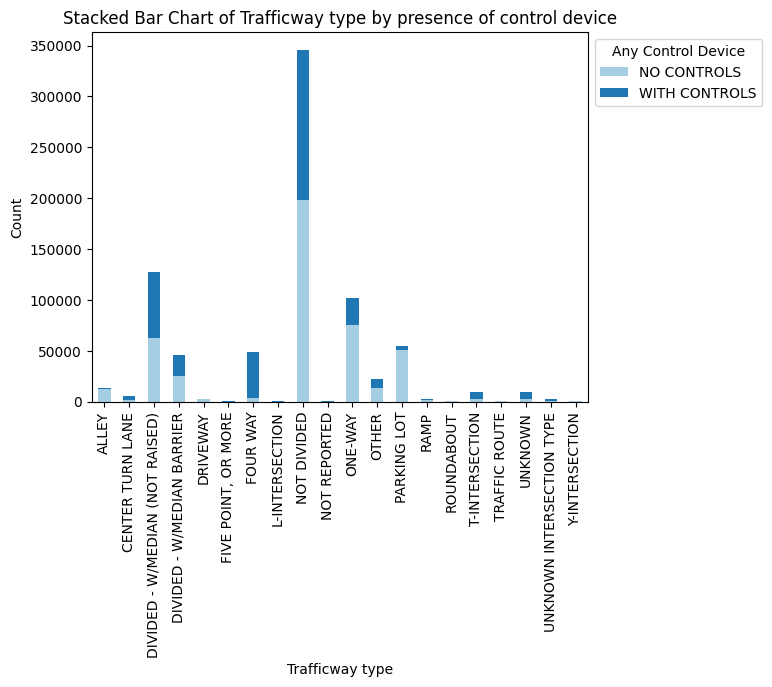

In [5]:
from scipy.stats import chi2_contingency
 
# Chi-sqaure test for relation between trafficway type and presence of control device
contingency_table = pd.crosstab(df['trafficway_type'], df['any_control_device'])
stat, p, dof, expected = chi2_contingency(contingency_table)

alpha = 0.05
print("Chi-sqaure test for the relationship between trafficway type and presence of control device")
print("Chi-square statistic:", stat)
print("p value is " + str(format(p, ".4e")))

if p <= alpha:
    print('There is a relationship between the variables.')
else:
    print('There is no relationship between the variables.')

palette_1 = sb.color_palette("Paired")
ax = contingency_table.plot(kind='bar', stacked=True, color=palette_1)

plt.xlabel('Trafficway type')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Stacked Bar Chart of Trafficway type by presence of control device')
legend = plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
legend.set_title('Any Control Device')

plt.show()

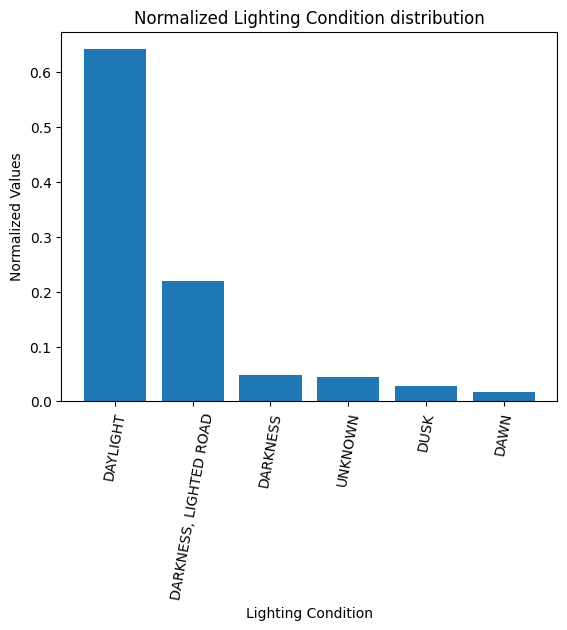

In [6]:
# Display the distribution of Lighting Condition
light_counts = df['lighting_condition'].value_counts()
light_normalized_values = np.array(light_counts) / np.sum(light_counts)

plt.bar(light_counts.index, light_normalized_values)
plt.xlabel('Lighting Condition')
plt.ylabel('Normalized Values')
plt.xticks(rotation=80)
plt.title('Normalized Lighting Condition distribution')

plt.show()

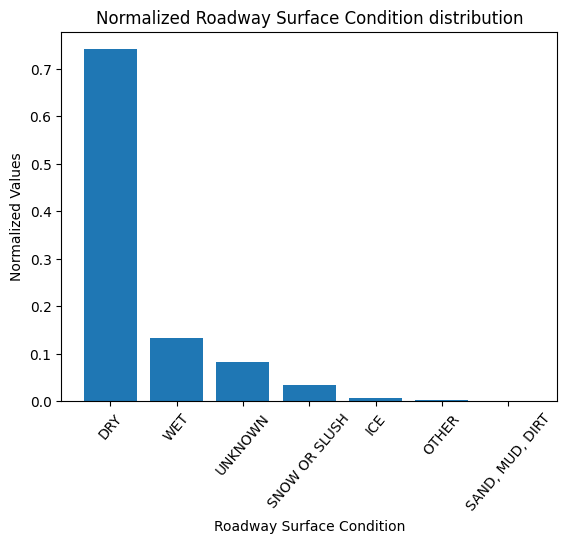

In [7]:
# Display the distribution of Roadway Surface Condition
road_cond_counts = df['roadway_surface_cond'].value_counts()
road_normalized_values = np.array(road_cond_counts) / np.sum(road_cond_counts)

plt.bar(road_cond_counts.index, road_normalized_values)
plt.xlabel('Roadway Surface Condition')
plt.ylabel('Normalized Values')
plt.xticks(rotation=50)
plt.title('Normalized Roadway Surface Condition distribution')

plt.show()

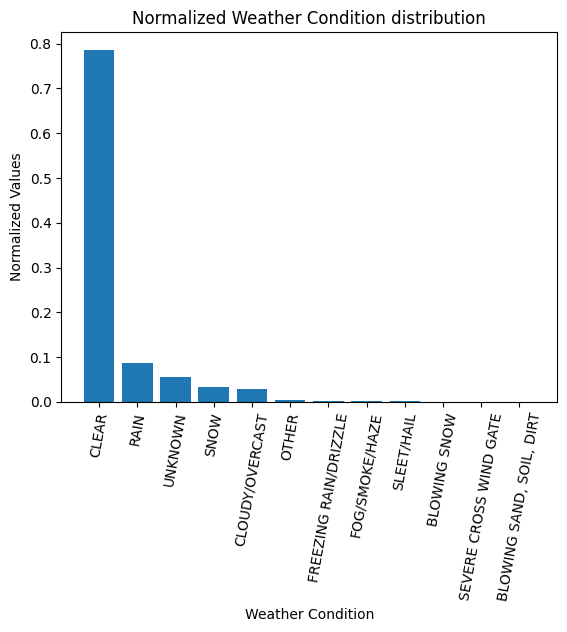

<Figure size 20000x20000 with 0 Axes>

In [8]:
# Display the distribution of Weather Condition
weather_condition_counts = df['weather_condition'].value_counts()
weather_normalized_values = np.array(weather_condition_counts) / np.sum(weather_condition_counts)

plt.bar(weather_condition_counts.index, weather_normalized_values)
plt.xlabel('Weather Condition')
plt.ylabel('Normalized Values')
plt.xticks(rotation=80)
plt.title('Normalized Weather Condition distribution')
plt.figure(figsize=(200, 200))

plt.show()

Chi-sqaure test for the relationship between road_surface_cond and weather_condition
Chi-square statistic: 1271712.0187284302
p value is 0.0000e+00
There is a relationship between the variables.


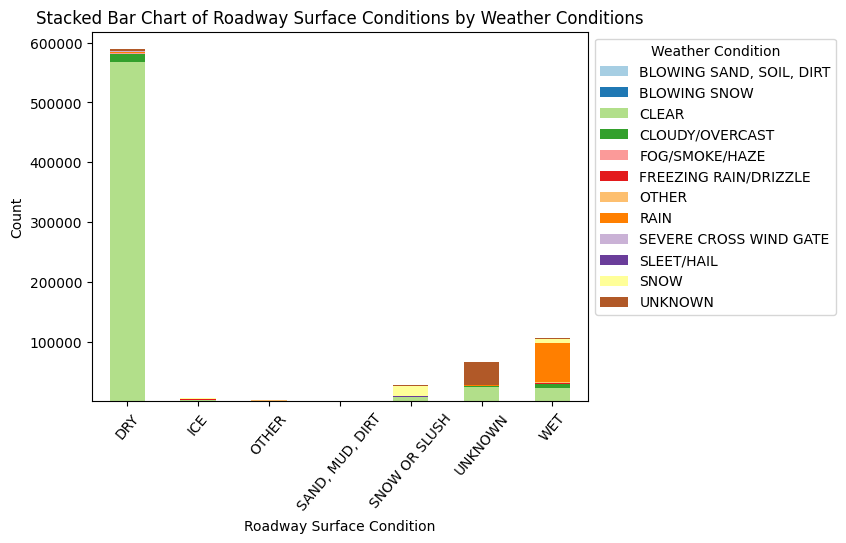

In [9]:
from scipy.stats import chi2_contingency
 
# Chi-sqaure test to test any relation between road_surface_cond and weather_condition
road_weather_contingency_table = pd.crosstab(df['roadway_surface_cond'], df['weather_condition'])
stat, p, dof, expected = chi2_contingency(road_weather_contingency_table)

alpha = 0.05
print("Chi-sqaure test for the relationship between road_surface_cond and weather_condition")
print("Chi-square statistic:", stat)
print("p value is " + str(format(p, ".4e")))

if p <= alpha:
    print('There is a relationship between the variables.')
else:
    print('There is no relationship between the variables.')

palette_2 = sb.color_palette("Paired", 12)
ax = road_weather_contingency_table.plot(kind='bar', stacked=True, color=palette_2)

plt.xlabel('Roadway Surface Condition')
plt.xticks(rotation=50)
plt.ylabel('Count')
plt.title('Stacked Bar Chart of Roadway Surface Conditions by Weather Conditions')
legend = plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
legend.set_title('Weather Condition')

plt.show()

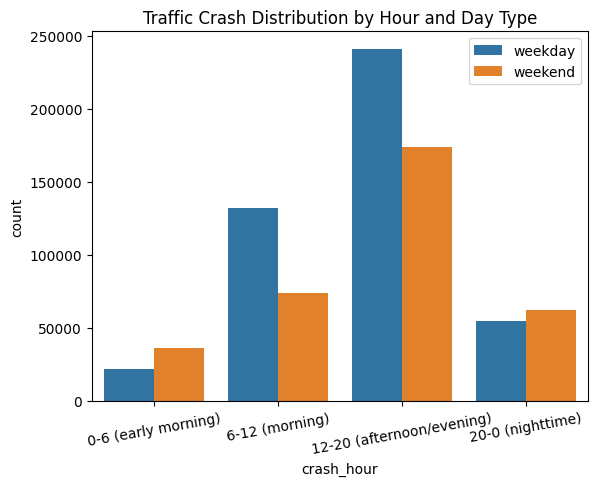

In [10]:
# Association between crash_day_of_week and crash_hour
ax = sb.countplot(x='crash_hour', hue='crash_day_of_week', data=df)
ax.set_xticklabels(['0-6 (early morning)', '6-12 (morning)', '12-20 (afternoon/evening)', '20-0 (nighttime)'], rotation=10)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['weekday', 'weekend'])

plt.title('Traffic Crash Distribution by Hour and Day Type')

plt.show()

In [11]:
# Create a heatmap
import folium
from folium.plugins import HeatMap

map_data = df.copy()
map_data = map_data.dropna(subset=['latitude', 'longitude'])
map_data['combination'] = map_data['latitude'].astype(str) + '_' + map_data['longitude'].astype(str)
frequent_crash_points = map_data['combination'].value_counts()[map_data['combination'].value_counts() > 200]
median_value = frequent_crash_points.idxmax()
filtered_data = map_data[map_data['combination'].isin(frequent_crash_points.index)]
filtered_data = filtered_data[filtered_data['combination']!=median_value]

heat_map = folium.Map(location=[filtered_data['latitude'].mean(), filtered_data['longitude'].mean()], zoom_start=11)

heat_mapping = list(zip(filtered_data['latitude'], filtered_data['longitude']))

HeatMap(data=heat_mapping).add_to(heat_map)
heat_map.save("heatmap.html")
heat_map

In [12]:
# Create cluster marker
from folium.plugins import MarkerCluster
cluster_map = folium.Map(location=[filtered_data['latitude'].mean(), filtered_data['longitude'].mean()], zoom_start=11)

marker_cluster = MarkerCluster().add_to(cluster_map)

for index, row in filtered_data.iterrows():
    folium.Marker([row['latitude'], row['longitude']]).add_to(marker_cluster)
cluster_map.save("marker_map.html")
cluster_map